In [1]:
using StarStats

Load the entire database of grids 

In [2]:
using Printf
using BenchmarkTools
function path_constructor(strings::Vector{String})
    DATA_FOLDER = ENV["STARSTATS_TEST_DATA_FOLDER"]
    return DATA_FOLDER*"/LMC/LMC_$(strings[1])_$(strings[2])_$(strings[3]).track.gz"
end
masses = [@sprintf("%.3f", x) for x in range(0.9,2.1,step=0.025)]
rotation = [@sprintf("%.2f", x) for x in range(0.0,0.9,step=0.1)]
overshoot = [@sprintf("%.2f", x) for x in range(0.5,4.5,step=0.5)]
#change name grid to e.g. star_grid
grid = ModelDataGrid([rotation,masses,overshoot],
    [:rotation,:logM,:overshoot])
#@benchmark 
load_grid(grid,path_constructor,gz_dataframe_loader_with_Teff_and_star_age_fix); 
compute_distances_and_EEPs(grid)

In [3]:
observable_names = [:logTeff, :logL, :vrot]
observable_values = [4.51974, 4.289877, 70.7195]
observable_errors = [0.2, 0.2, 10]

3-element Vector{Float64}:
  0.2
  0.2
 10.0

In [6]:
using Turing, Distributions

@model function star_model(logTeff_obs, logTeff_err, logL_obs, logL_err, vrot_obs, vrot_err, grid)
  x ~ Uniform(0,3)
  logM ~ Uniform(0.9, 1.5)
  rotation ~ Uniform(0,0.9)
  overshoot ~ Uniform(0.5,1.5)
  logTeff = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:logTeff,x)
  logL = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:logL,x)
  vrot = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:vrot,x)
  

  logTeff_obs ~ Normal(logTeff, logTeff_err)
  logL_obs ~ Normal(logL, logL_err)
  vrot_obs ~ Normal(vrot, vrot_err)
  return logTeff_obs, logL_obs, vrot_obs
end

star_model (generic function with 2 methods)

In [7]:
using Logging
Logging.disable_logging(Logging.Warn)
## Here needs more analysis for optimization
num_chains=4

observed_star_model = star_model(4.51974, 0.2, 4.289877, 0.2, 70.7195, 20, grid)
star_chains = mapreduce(c -> sample(observed_star_model, NUTS(500,0.9), 20000;stream=false, progress=true), chainscat, 1:num_chains)

Chains MCMC chain (20000×16×4 Array{Float64, 3}):

Iterations        = 501:1:20500
Number of chains  = 4
Samples per chain = 20000
Wall duration     = 39.99 seconds
Compute duration  = 36.93 seconds
parameters        = x, logM, rotation, overshoot
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           x    1.0527    0.6415     0.0023    0.0089    3944.2056    1.0016   ⋯
        logM    1.0862    0.0837     0.0003    0.0005   25039.7608    1.0000   ⋯
    rotation    0.1255    0.0613     0.0002    0.0022     466.8944    1.0145   ⋯
   overshoot    0.9921    0.2897     0.0010    0.0024   20679.7397    1.0006   ⋯
                                         

In [8]:
using QuadGK
function chain_credible_interval(values, fraction,num_points,weights)
    maxval= maximum(logM)
    minval = minimum(logM)
    my_kde = kde(logM, weights=weights)
    kde_function = x-> pdf(my_kde, x)
    
    integral = quadgk(kde_function,minval,maxval, rtol=1e-8)[1]
    
    xvalues = collect(LinRange(minval,maxval,num_points))
    yvalues = kde_function(xvalues)
    max_valy = findmax(yvalues)
    maxx = xvalues[max_valy[2]]
    maxy = max_valy[1]
    
    function kde_function2(x, kde_function, bound)
        value = kde_function(x)
        if value>bound
            return value
        else
            return 0
        end
    end
    minbound = 0
    maxbound = maxy
    newbound = 0
    for i in 1:15
        newbound = 0.5*(minbound+maxbound)
        integral2 = quadgk(x -> kde_function2(x,kde_function,newbound), minval, maxval, rtol=1e-8)[1]
        newfraction = integral2/integral
        if newfraction>fraction
            minbound = newbound
        else
            maxbound = newbound
        end
    end
    filtered_xvalues = xvalues[yvalues.>newbound]
    return ([maximum(filtered_xvalues), maxx, minimum(filtered_xvalues)], newbound)
end

chain_credible_interval (generic function with 1 method)

In [9]:
num_points = 10000
values = logM
fraction = 0.9


CI = chain_credible_interval(values, fraction, num_points,dtdx)
#@show dtdx

UndefVarError: UndefVarError: logM not defined

In [10]:
observable_names = [:logTeff, :logL, :vrot]
observable_values = [4.51974, 4.289877, 70.7195]
observable_errors = [0.2, 0.2, 20]
# potentially parallelize this
grid_likelihood = ModelDataGridLikelihood(grid, observable_names, observable_values, observable_errors);
CI2 = credible_interval(grid_likelihood, :logM,0.9,1_000_000)

UndefVarError: UndefVarError: ModelDataGridLikelihood not defined

In [ ]:
#using Plots
plot()
ml= marginalized_likelihood(grid_likelihood,[:logM])
plot!(grid.input_values[2], ml./maximum(ml))
hline!([CI2[2]/maximum(ml)])
vline!(CI2[1])

my_kde = kde(logM, weights=dtdx)
plot!(x->pdf(my_kde,x)/pdf(my_kde,CI[1][2]), xrange=[0.8, 2.1])

hline!([CI[2]/pdf(my_kde,CI[1][2])])
vline!(CI[1])

To do :

1. MCMC code into its own  file within package
    - make sampling code work with arbitrary observables
    - make credible interval code flexible 
    - optimize the credible interval code 
    - create  pretty corner plots 
    - 
2. grid computed 
3. create simple interpolation interface 
4. change longM with values in credible interval bla
5. make ticks consistent in corner plot
6. use interpolation to get bounds on 1D marginalized distribution
7. get proper parsing for report of CIs on top od 1D marginalized distribution

In [9]:
logM = star_chains[:,:logM, :1].data
append!(logM,star_chains[:,:logM, :2].data)
append!(logM,star_chains[:,:logM, :3].data)
append!(logM,star_chains[:,:logM, :4].data)

rotation = star_chains[:,:rotation, :1].data
append!(rotation,star_chains[:,:rotation, :2].data)
append!(rotation,star_chains[:,:rotation, :3].data)
append!(rotation,star_chains[:,:rotation, :4].data)

overshoot= star_chains[:,:overshoot, :1].data
append!(overshoot,star_chains[:,:overshoot, :2].data)
append!(overshoot,star_chains[:,:overshoot, :3].data)
append!(overshoot,star_chains[:,:overshoot, :4].data)

x= star_chains[:,:x, :1].data
append!(x,star_chains[:,:x, :2].data)
append!(x,star_chains[:,:x, :3].data)
append!(x,star_chains[:,:x, :4].data)

dtdx=zeros(length(logM))
for i in 1:length(logM)
    dtdx[i]= interpolate_grid_quantity(grid,[rotation[i], logM[i], overshoot[i]],:dtdx,x[i])
end

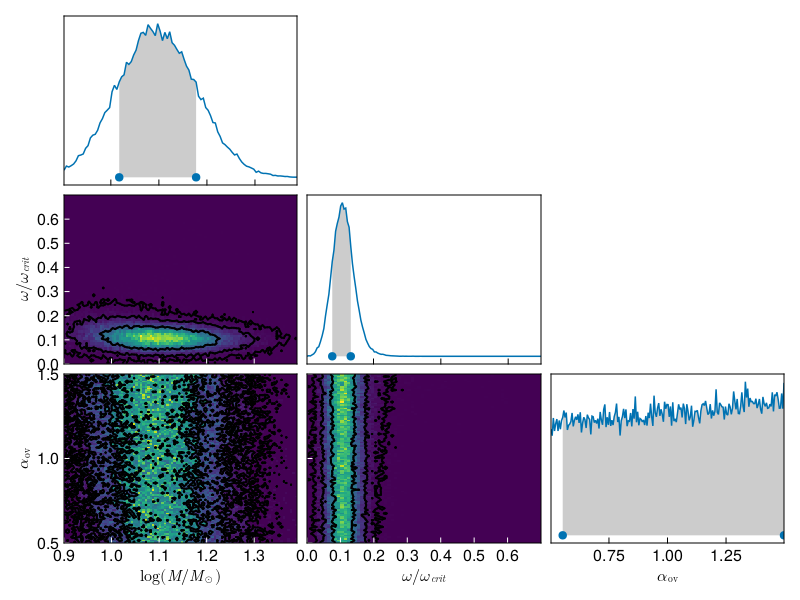

In [96]:
using LaTeXStrings
using Makie
using CairoMakie
using StatsBase

names = [:logM, :rotation, :overshoot]
chain_values = Dict(:logM=>logM, :rotation=>rotation, :overshoot=>overshoot)
chain_weights = dtdx
fractions =[0.68,0.95, 0.997]
fraction_1D = 0.68
figure= Figure()#resolution = (676, 507))
label_names = [L"\log(M/M_{\odot})", L"\omega/\omega_{crit}", L"\alpha_\mathrm{ov}" ]

create_corner_plot(chain_values,names,label_names, chain_weights, fractions, fraction_1D, figure, show_CIs = false)

note: allow kde option in marginalized 1d plot
add credible interval for 1d plot, add 1d fraction interval  
move all this plotting functions to afile within the  package


In [69]:
L"\alpha=10"*L"0.1^10"

"\$\\alpha=10\$\$0.1^10\$"